# Mounting Drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

# Imports

In [0]:
## Imports
import os
import sys
import cv2
from google.colab.patches import cv2_imshow
import imutils
import dlib
from imutils.face_utils import FaceAligner
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import load_model
from joblib import dump, load

dir_path = 'drive/My Drive/ML/'

sys.path.insert(0, dir_path)

from model import create_model

Using TensorFlow backend.


# Face Detection Functions

In [0]:
proto_path = dir_path + 'deploy.prototxt.txt'
model_path = dir_path + 'res10_300x300_ssd_iter_140000.caffemodel'
predictor_path = dir_path + 'shape_predictor_68_face_landmarks.dat'

predictor = dlib.shape_predictor(predictor_path)
net = cv2.dnn.readNetFromCaffe(proto_path, model_path)
detector = dlib.get_frontal_face_detector()
fa = FaceAligner(predictor, desiredFaceWidth=227)

def detect_face_dl(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = box.astype("int")
            y = (start_y - 10) if (start_y - 10) > 10 else (start_y + 10)
            # cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
            rect = dlib.rectangle(left=int(start_x), top=int(start_y), right=int(end_x), bottom=int(end_y))
            image_centered = fa.align(image, gray, rect)
            
            return image_centered
          

def detect_face_dlib(image, gray, rects):
    for (i, rect) in enumerate(rects):
        image_centered = fa.align(image, gray, rect)
        return image_centered
      
      
def get_face(image):
  image_low = imutils.resize(image, width=800)
  gray = cv2.cvtColor(image_low, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)
  if len(rects) > 0:
    face = detect_face_dlib(image_low, gray, rects)
  else:
    face = detect_face_dl(image)
  return face


model = create_model()
model.load_weights(dir_path + 'nn4.small2.v1.h5')

def get_encodings(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = (image / 255.).astype(np.float32)
  return model.predict(np.expand_dims(image, axis=0))[0]

Instructions for updating:
Colocations handled automatically by placer.


# Loading Dictionaries

In [0]:
emotion_2_idx = {"neutral":0, "happy":1, "sad":2, "disgust":3, "anger":4, "fear":5, "surprise":6, 'angry':4, 'surprise':6}

idx_2_emotion = {v: k for k, v in emotion_2_idx.items()}

roll_2_idx = {'1641002': 0, '1641003': 1, '1641005': 2, '1641006': 3, '1641007': 4, '1641010': 5, '1641011': 6, '1641013': 7, 
             '1641014': 8, '1641015': 9, '1641016': 10, '1641017': 11, '1641020': 12, '1641021': 13, '1641023': 14, '1641025': 15, 
             '1641026': 16, '1641027': 17, '1641028': 18, '1641029': 19, '1641030': 20, '1641031': 21, '1641034': 22, '1641035': 23, 
             '1641036': 24, '1641038': 25, '1641039': 26, '1641040': 27, '1641043': 28, '1641044': 29, '1641046': 30, '1641047': 31, 
             '1641052': 32, '1641054': 33, '1641055': 34, '1641057': 35, '1641059': 36, '1641060': 37, '1641061': 38, '1641062': 39, 
             '1641065': 40, '1641066': 41, '1641067': 42, '1641068': 43, '1641069': 44, '1641071': 45, '1641072': 46, '1641073': 47, 
             '1844001': 48, '1844002': 49, '1844004': 51, '1844005': 52, '1844006': 53, '1844007': 54, '1844008': 55, '1844010': 56, 
             '1849007': 57, '1849011': 58, '1849012': 59, '1849013': 60, '201501103': 61, '1641045': 62}

idx_2_roll = {v: k for k, v in roll_2_idx.items()}

# Loading Model

In [0]:
face_svm_clf = load(dir_path + 'face_recog_svm_clf.joblib') 
emotion_cnn_clf = load_model(dir_path + 'emotion_cnn_clf.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
u, s = np.load(dir_path + 'ms.npy')

# Testing the provided face

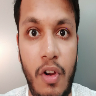

In [0]:
test_image_path = 'drive/My Drive/ML/test/1641035_Male_Fear_RGB_fliplr_noise.png'


image = cv2.imread(test_image_path)
face = get_face(image)
face = cv2.resize(face, (96,96))
cv2_imshow(face)
encodings = get_encodings(face)
encodings = np.divide((encodings - u), s)
encodings = encodings.reshape(1,128)

face_prediction = face_svm_clf.predict(encodings)

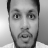

In [0]:
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = cv2.resize(face, (48,48))
cv2_imshow(face)
face = face.reshape(1, 48, 48, 1)

emotion_prediction = emotion_cnn_clf.predict(face)
emotion_prediction = np.argmax(emotion_prediction)

In [0]:
emotion = idx_2_emotion[emotion_prediction]
roll = idx_2_roll[face_prediction[0]]
print(roll)
print(emotion)

1641035
fear


In [0]:
def get_rect(image):
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  for i in range(0, detections.shape[2]):
      confidence = detections[0, 0, i, 2]
      if confidence > 0:
          box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
          (start_x, start_y, end_x, end_y) = box.astype("int")
          return (start_x, start_y, end_x, end_y)

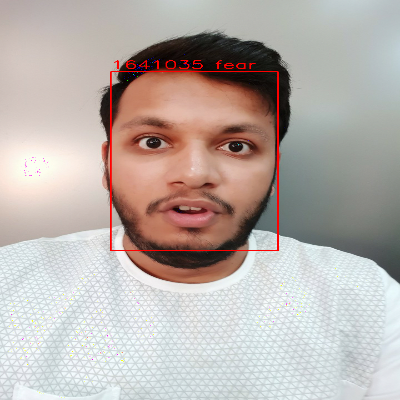

In [0]:
(start_x, start_y, end_x, end_y) = get_rect(image)
cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
y = start_y - 10 if start_y - 10 > 10 else start_y + 10
cv2.putText(image, roll+" "+emotion, (start_x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)
image = cv2.resize(image, (400,400))
cv2_imshow(image)